In [23]:
import sys 
from pathlib import Path
project_root = (Path.cwd() / "../../").resolve()
sys.path.append(str(project_root))

In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import product
import numpy as np


In [22]:
data_path = project_root / "data"

# Loading The Data

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* **Id**  an Id that represents a (Store, Date) duple within the test set
* **Store**  a unique Id for each store
* **Sales**  the turnover for any given day (this is what you are predicting)
* **Customers**  the number of customers on a given day
* **Open**  an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday**  indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday**  indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType**  differentiates between 4 different store models: a, b, c, d
* **Assortment**  describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance**  distance in meters to the nearest competitor store
* **CompetitionOpenSince[Month/Year]**  gives the approximate year and month of the time the nearest competitor was opened
* **Promo**  indicates whether a store is running a promo on that day
* **Promo2**  Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since[Year/Week]**  describes the year and calendar week when the store started participating in Promo2
* **PromoInterval**  describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


In [3]:
# define data types
from typing import Union, Text

state_holiday_name_map = {
    "a": "public", 
    "b" : "Easter holiday", 
    "c" : "Christmas", 
    "0" : "no holiday"
}

assortment_name_map = {
    "a": "basic", 
    "b" : "extra", 
    "c" : "extended"
}
    
data_columns = ["Date"]
columns_types = {
    "Open": bool,
    "Promo": bool, 
    "SchoolHoliday": bool, 
    "StateHoliday": "category", 
    "StoreType" : "category", 
    "Assortment": "category", 
    "Promo2": bool
}

## Training Data
### Load and conver to Right Types

In [4]:
# load train data
train = pd.read_csv(
    data_path / "train.csv", 
    index_col=["Store", "Date"],
    parse_dates=data_columns, 
    dtype=columns_types
)

train["StateHoliday"] = train["StateHoliday"].cat.rename_categories(state_holiday_name_map)
train.isna().sum()
train

,,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,Date,,,,,,,
1,2015-07-31,5,5263,555,True,True,no holiday,True
2,2015-07-31,5,6064,625,True,True,no holiday,True
3,2015-07-31,5,8314,821,True,True,no holiday,True
4,2015-07-31,5,13995,1498,True,True,no holiday,True
5,2015-07-31,5,4822,559,True,True,no holiday,True
...,...,...,...,...,...,...,...,...
1111,2013-01-01,2,0,0,False,False,public,True
1112,2013-01-01,2,0,0,False,False,public,True
1113,2013-01-01,2,0,0,False,False,public,True


In [5]:
# Add more seasonal/time features

date = train.index.get_level_values("Date")
start_days = min(date)
train = train.assign(
    Day=date.day,
    Year=date.year,
    Month=date.month,
    DayOfYear=date.dayofyear,
    DaysSinceStart=(date - start_days).days,
)

In [6]:
# Could group stores  shared public holidays (indicates groups of bundesland)
SchoolHoliday_per_store = train.reset_index().pivot(index='Store', columns='Date', values='SchoolHoliday')
holiday_groups = SchoolHoliday_per_store.reset_index().groupby(SchoolHoliday_per_store.columns.to_list()).ngroup()
holiday_groups.index.name = 'Store'
holiday_groups.name = "HolidayGroup"
holiday_groups = holiday_groups.astype("category")

### Select Subset

In [7]:
# Select the  top performing stores that have to 10% of the sales
total_sales = train["Sales"].sum()
sales_per_store = train.groupby(by="Store").agg({"Sales": "sum"}).sort_values(by="Sales", ascending=False)
sales_per_store["accumulated_sales"] = sales_per_store["Sales"].cumsum()
top_stores_sales = sales_per_store.query("accumulated_sales <= @total_sales * 0.1")

subset_train = train.join(top_stores_sales.drop(columns=["accumulated_sales", "Sales"]), on="Store", how="inner")

In [8]:
subset_train

DayOfWeek  Sales  Customers   Open  Promo StateHoliday  \
Store Date                                                                 
84    2015-07-31          5  14949       1439   True   True   no holiday   
      2015-07-30          4  12928       1255   True   True   no holiday   
      2015-07-29          3  15367       1511   True   True   no holiday   
      2015-07-28          2  14892       1383   True   True   no holiday   
      2015-07-27          1  16104       1412   True   True   no holiday   
...                     ...    ...        ...    ...    ...          ...   
1114  2013-01-05          6  18856       3065   True  False   no holiday   
      2013-01-04          5  18371       3036   True  False   no holiday   
      2013-01-03          4  18463       3211   True  False   no holiday   
      2013-01-02          3  20642       3401   True  False   no holiday   
      2013-01-01          2      0          0  False  False       public   

                  SchoolHoliday  Day  Year  Month  DayOfYear  DaysSinceStart  
Store Date                                                                    
84    2015-07-31           True   31  2015      7        212             941  
      2015-07-30           True   30  2015      7        211             940  
      2015-07-29           True   29  2015      7        210             939  
      2015-07-28           True   28  2015      7        209             938  
      2015-07-27           True   27  2015      7        208             937  
...                         ...  ...   ...    ...        ...             ...  
1114  2013-01-05          False    5  2013      1          5               4  
      2013-01-04           True    4  2013      1          4               3  
      2013-01-03           True    3  2013      1          3               2  
      2013-01-02           True    2  2013      1          2               1  
      2013-01-01           True    1  2013      1          1               0  

[49742 rows x 12 columns]

## Stores
### Load Data and Convert Formats

In [9]:
stores = pd.read_csv(data_path / "store.csv", index_col=["Store"], dtype=columns_types)

stores["Assortment"] = stores["Assortment"].cat.rename_categories(assortment_name_map)

stores["CompetitionOpenSince"] = pd.to_datetime(
    stores[["CompetitionOpenSinceYear", "CompetitionOpenSinceMonth"]]
    .rename(columns={"CompetitionOpenSinceYear":"year", "CompetitionOpenSinceMonth":"month"})
    .assign(day=1)
)
stores = stores.drop(["CompetitionOpenSinceYear", "CompetitionOpenSinceMonth"], axis=1)

# assuming monday of the first week
assert ((stores["Promo2SinceWeek"].notna()  & stores["Promo2SinceYear"].notna()) == stores["Promo2"]).all()
stores_with_promo_date = stores.query("Promo2SinceWeek.notna() and Promo2SinceYear.notna()")
formatted_date = stores_with_promo_date["Promo2SinceYear"].astype(int).astype(str) + " " + stores_with_promo_date["Promo2SinceWeek"].astype(int).astype(str) + " 1" 
promo_start_date = pd.to_datetime(formatted_date, format="%Y %W %w", errors="coerce")
promo_start_date.name="Promo2Since"
stores = (
    stores
    .join(promo_start_date , on="Store")
    .drop(["Promo2SinceWeek", "Promo2SinceYear"], axis=1)
)
stores.isna().sum()

StoreType                 0
Assortment                0
CompetitionDistance       3
Promo2                    0
PromoInterval           544
CompetitionOpenSince    354
Promo2Since             544
dtype: int64

In [10]:
# For each stores get for each month if it participates in the promo

month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
stores["PromoInterval"] = stores["PromoInterval"].fillna(value="").str.split(",").apply(lambda m_names: [month.index(m_name) + 1 for m_name in m_names] if m_names != [""] else [])

In [11]:
# Add holiday_groups to stores
stores = stores.join(holiday_groups, on="Store", how="left")

In [12]:
data = subset_train.join(stores, on="Store", how="inner").sort_index(level=1)

In [13]:
# Infer if Promo2 at day x
def is_promo2_at_day(storeId : int, date : pd.Timestamp) -> bool:
    if storeId not in stores.index.get_level_values(0):
        raise ValueError("StoreId not in store_data")
    store_data = stores.loc[storeId]
    if not store_data["Promo2"]: 
        return False
    return date.month in store_data["PromoInterval"] and date > store_data["Promo2Since"]
    
data["Promo2"] = data.apply(lambda row: is_promo2_at_day(*row.name), axis=1)  
data = data.drop(["Promo2Since", "PromoInterval"], axis=1)      


In [14]:
# Infer days since the competition opened
def days_since_competition_opened(storeId : int, date : pd.Timestamp) -> int:
    if storeId not in stores.index.get_level_values(0):
        raise ValueError("StoreId not in store_data")
    store_data = stores.loc[storeId]
    if not store_data["CompetitionOpenSince"] or pd.isna(store_data["CompetitionOpenSince"]): 
        return 0
    return (date - store_data["CompetitionOpenSince"]).days
data["CompetitionOpenSinceDays"] = data.apply(lambda row: days_since_competition_opened(*row.name), axis=1)
data["CompetitionOpen"] = data["CompetitionOpenSinceDays"] > 0
data = data.drop(["CompetitionOpenSince"], axis=1)

# Sales Over Time

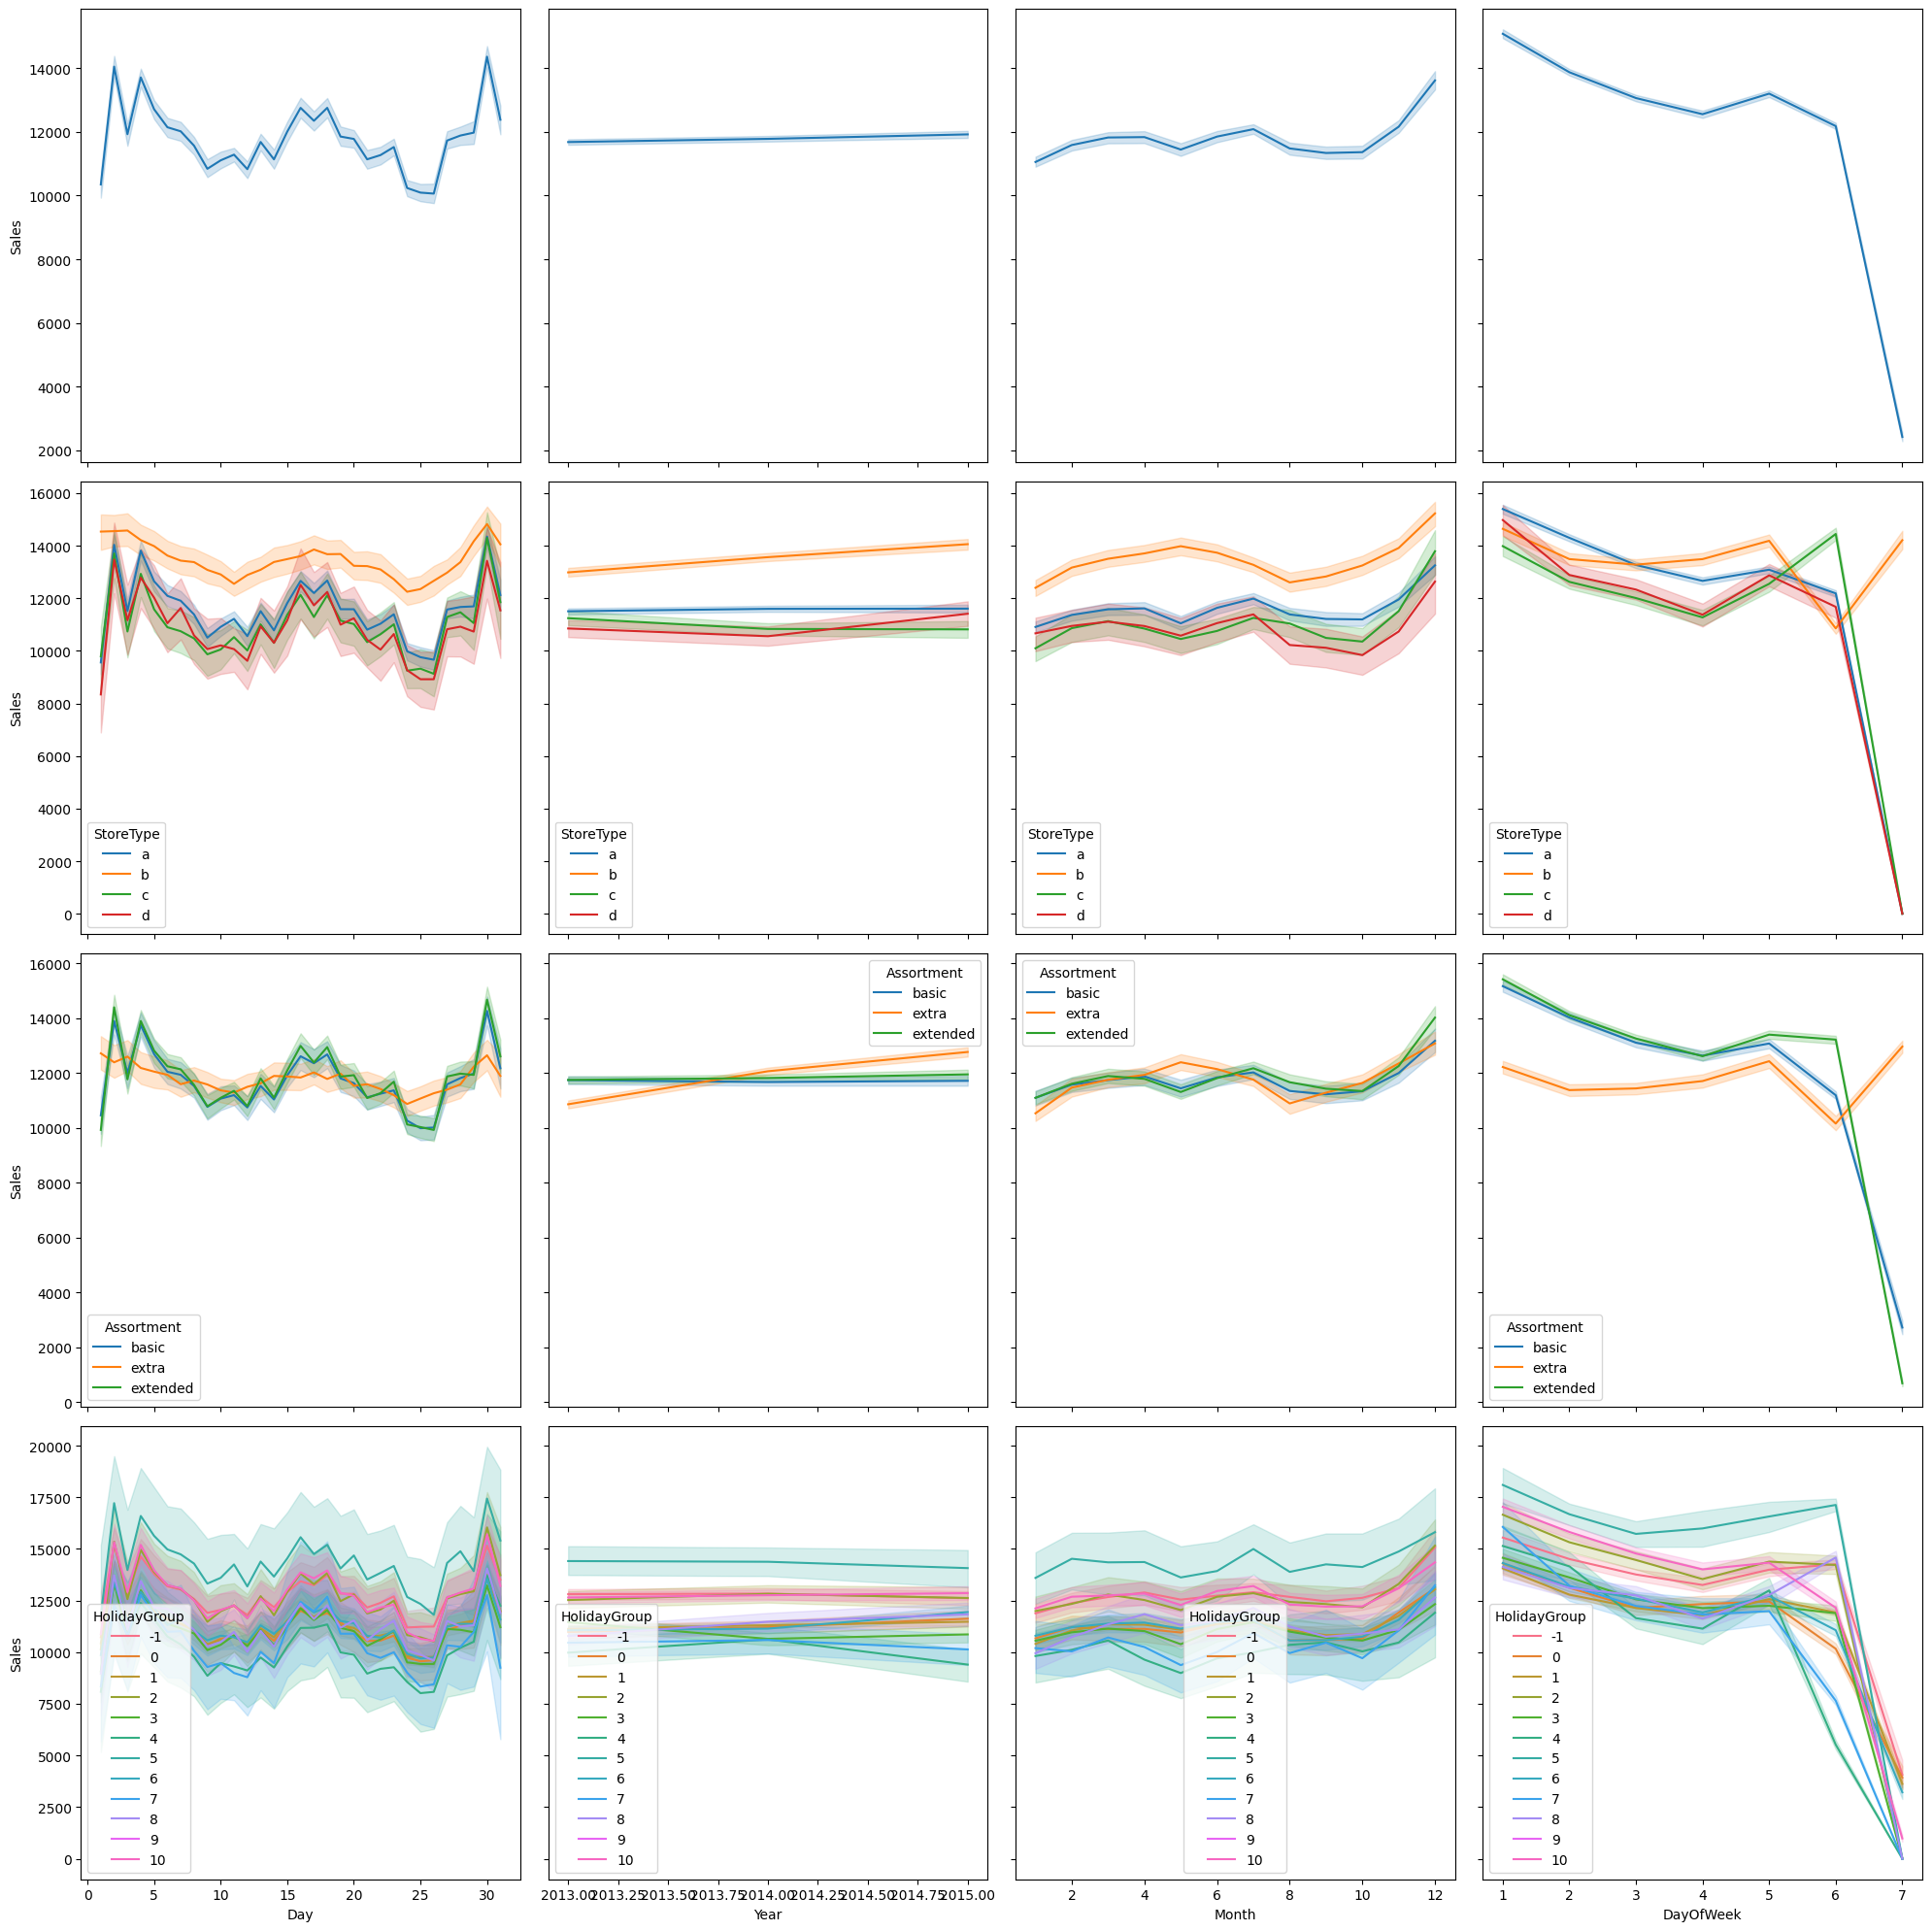

In [639]:
freqs = ["Day", "Year", "Month", "DayOfWeek"]
cats = [None, "StoreType", "Assortment", "HolidayGroup"]

fig, axes = plt.subplots(
    nrows=len(cats), 
    ncols=len(freqs), figsize=(20, 20), sharex="col", sharey="row")
for (cat, freq), ax in zip(product(cats, freqs), axes.flat):
    sns.lineplot(x=freq, y="Sales", data=data, hue=cat, ax=ax)
    

plt.tight_layout()

### Takeaways 
* Day probalby not importat
* StoreType, HolidayGroup and Assort might help

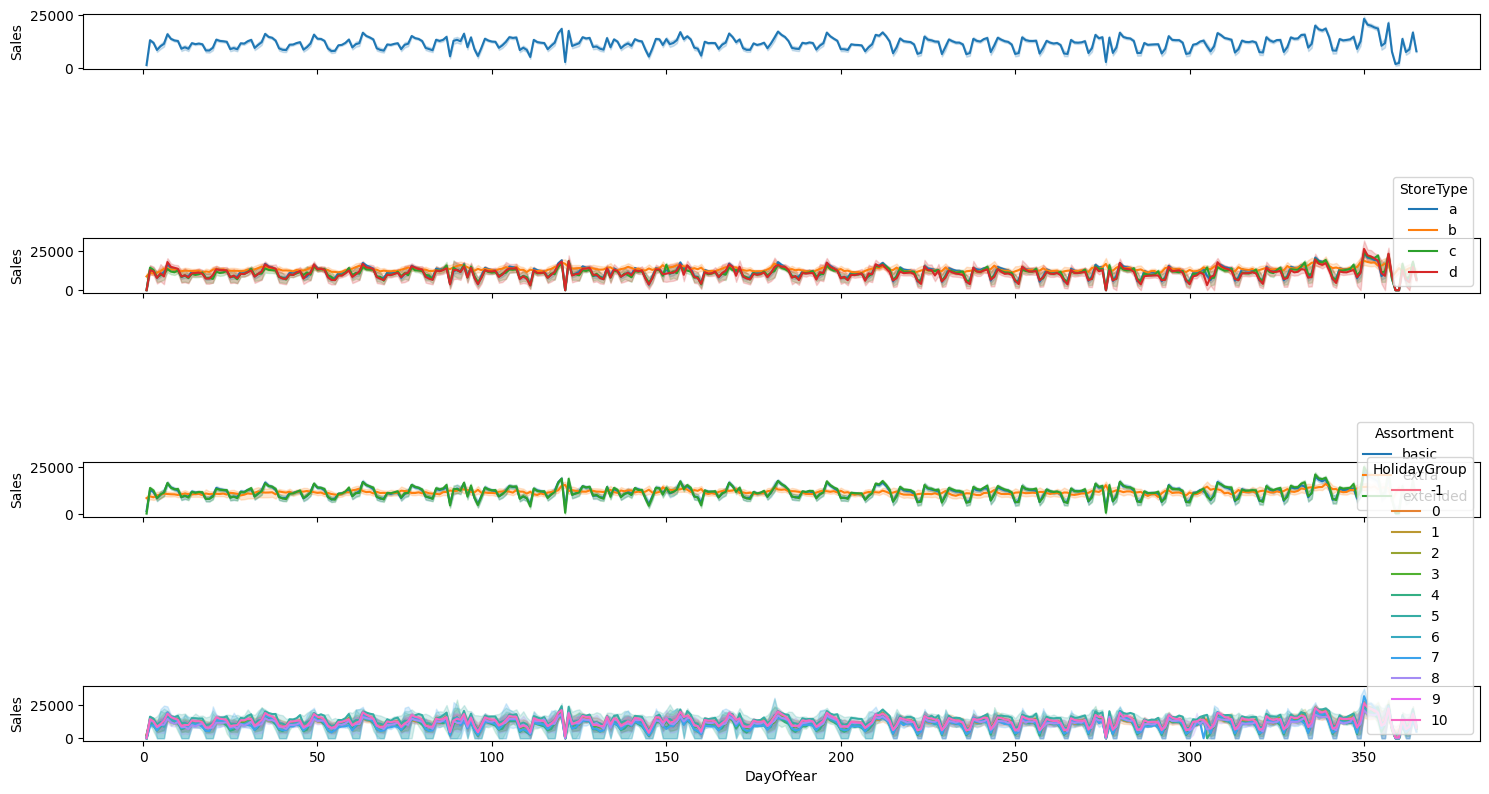

In [640]:
cats = [None, "StoreType", "Assortment", "HolidayGroup"]

fig, axes = plt.subplots(
    nrows=len(cats), figsize=(15, 8), sharex="col", sharey="row")
for cat, ax in zip(cats, axes.flat):
    sns.lineplot(x="DayOfYear", y="Sales", data=data, hue=cat, ax=ax)
    

plt.tight_layout()

## Features Distributions
### Non-Categorical

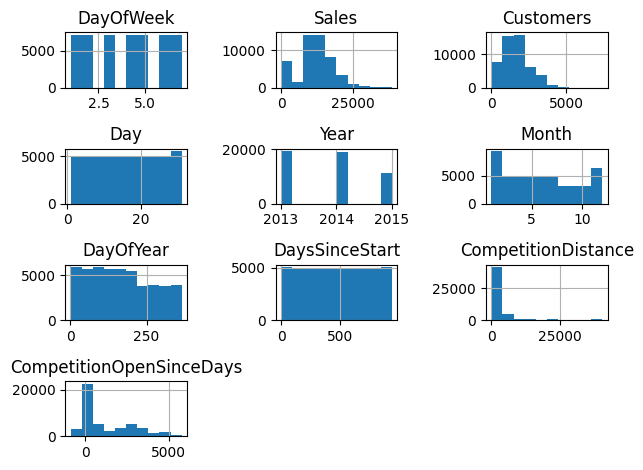

In [641]:
non_cat = data.columns[(data.dtypes != bool) & (data.dtypes != "category")]
data[non_cat].hist()
plt.tight_layout()

### Takeawys
1. CompetetionDistance: x transform CompetetionDistance to make it more semetric
2. Normalize Continous Fatures: Year, Month, DayOfYear, DayOfWeek 
3. Maybe (depending on classifier) convert StoreTye, HolidayGroup, Assortment to bianry indicators



<AxesSubplot:>

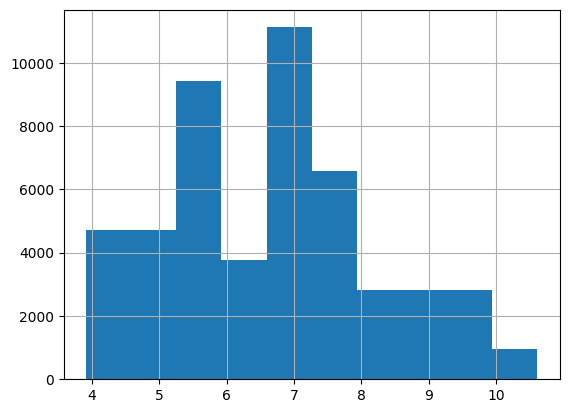

In [642]:
data["CompetitionDistanceLog"] = data["CompetitionDistance"].apply(np.log)
data["CompetitionDistanceLog"].hist()

<AxesSubplot:>

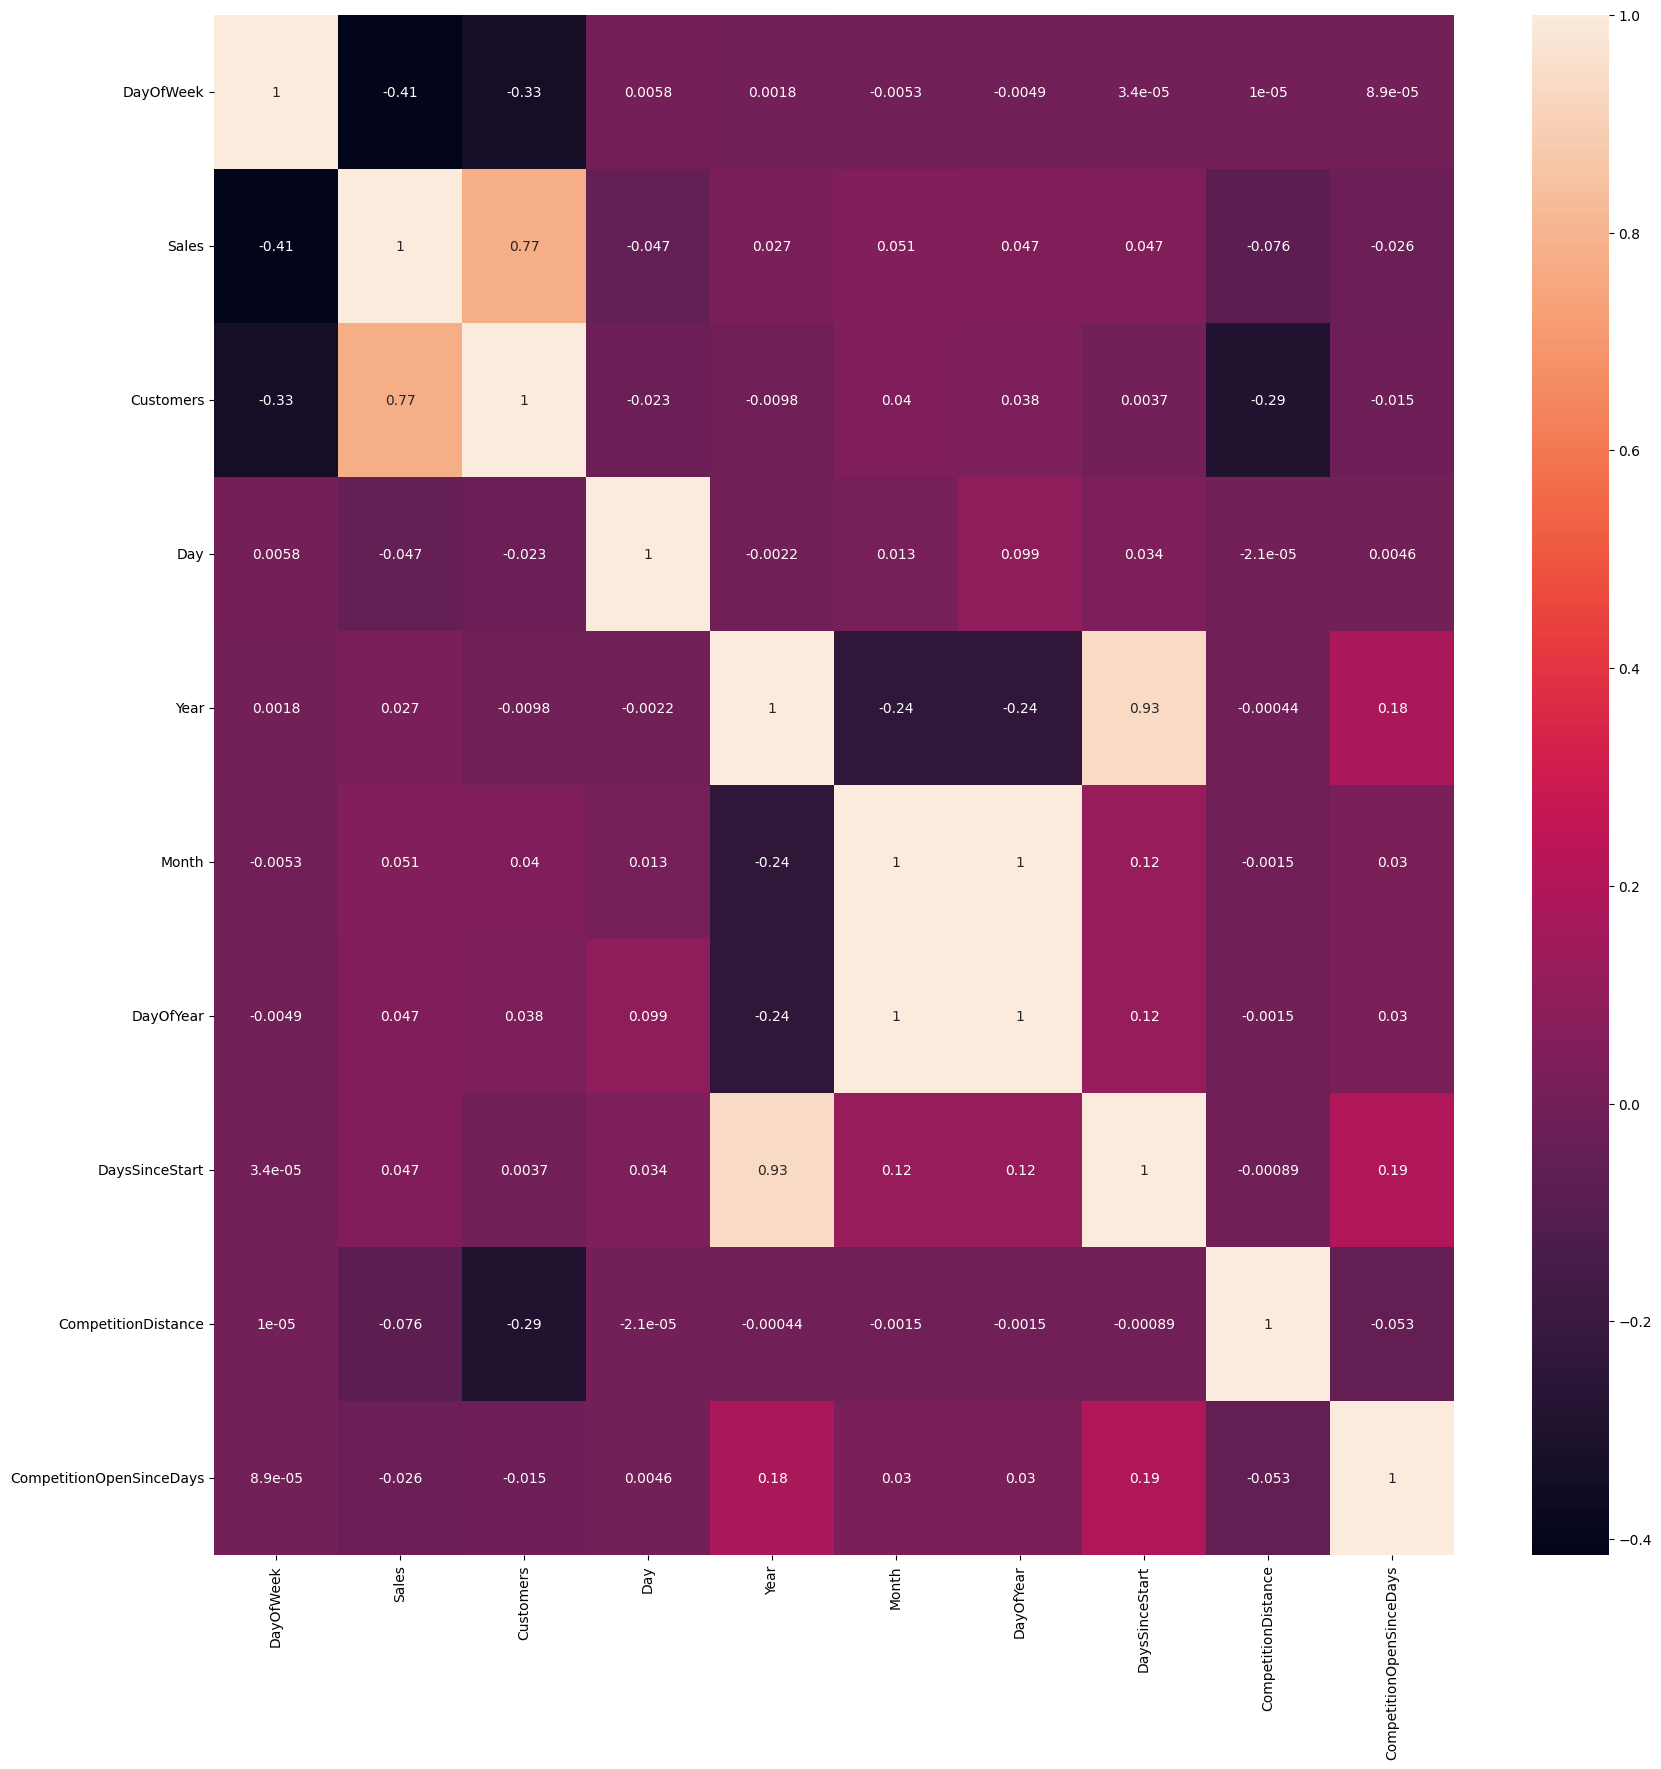

In [643]:
correlations = data[non_cat].corr(method="spearman")
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)

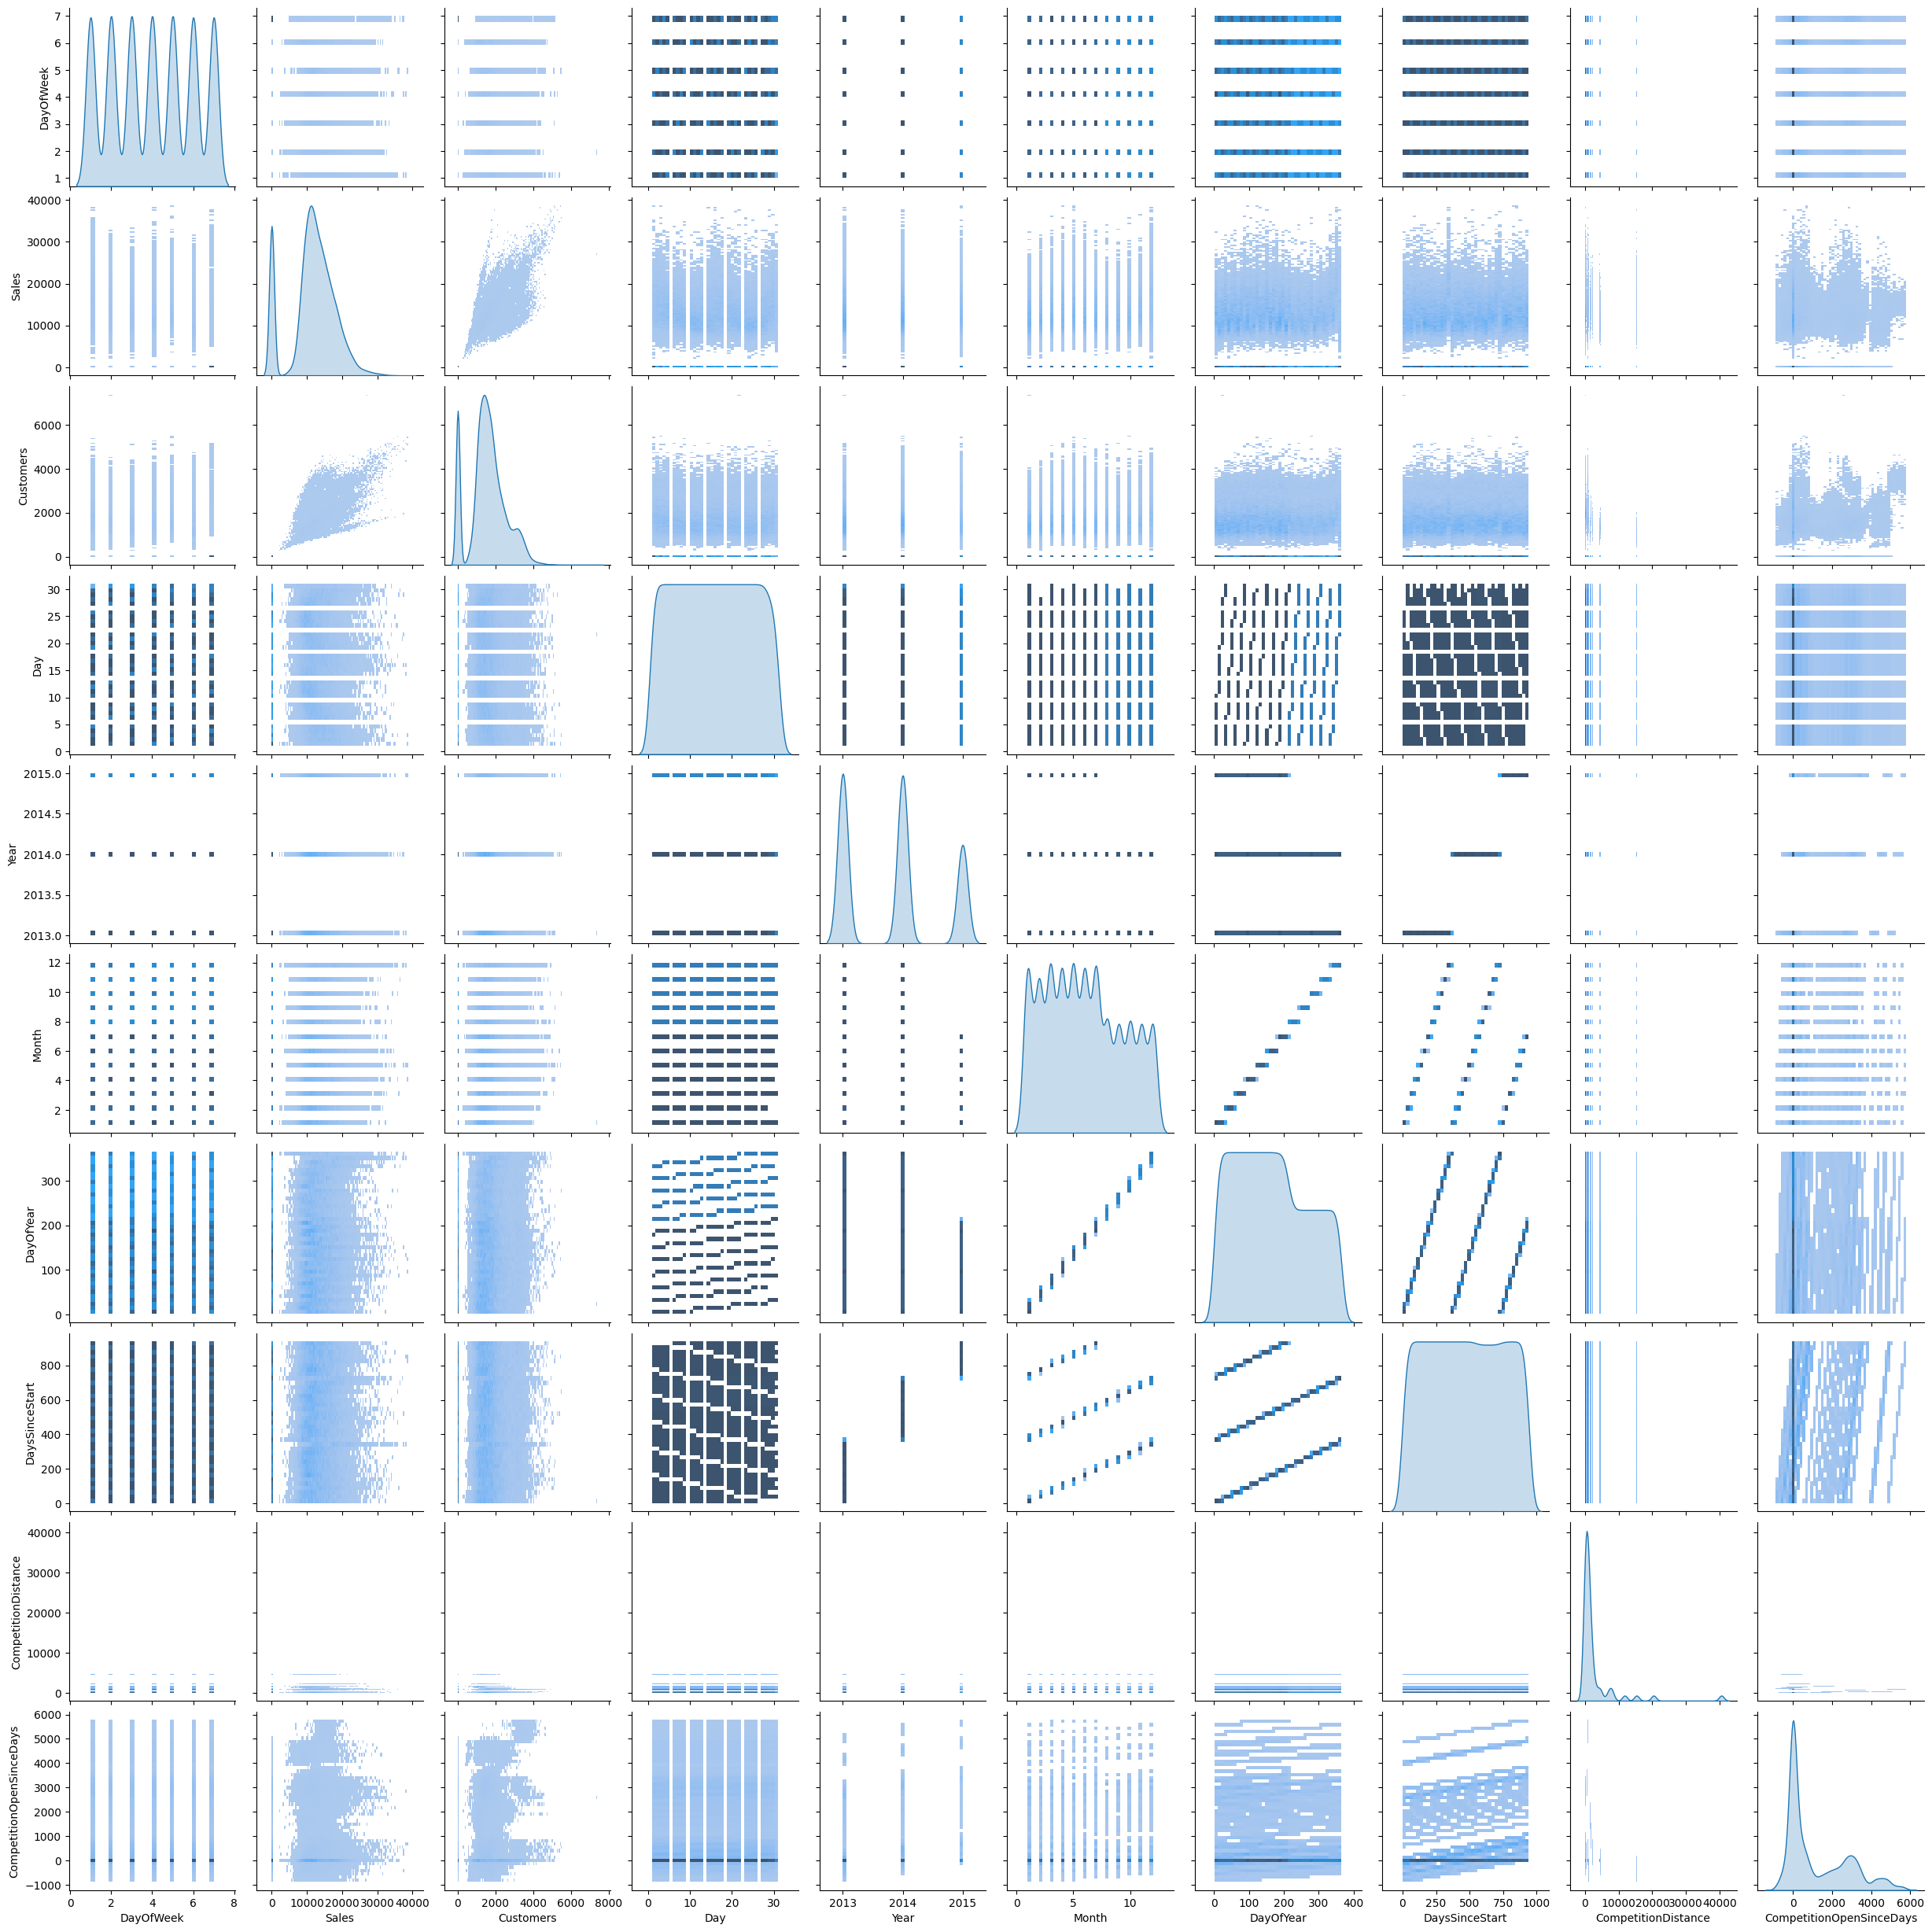

In [644]:
sns.pairplot(data[non_cat], kind='hist', diag_kind='kde')

# Cat to Dummy

In [15]:
cat_cols = data.columns[data.dtypes == "category"]
data = pd.get_dummies(data, columns=cat_cols)

# Binary to 0/1

In [16]:
bin_cols = data.columns[(data.dtypes == bool)]
data[bin_cols] = data[bin_cols].astype(int)

# Prepare training Data

In [17]:

data = data.drop("Customers", axis=1)
y = data["Sales"]
X = data.drop("Sales", axis=1)

In [19]:
pwd

'/Users/max/Desktop/assessment-max/rossmann/model'

In [24]:
from rossmann.model.utils import rmspe
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


In [650]:
predictor = LinearRegression()
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)
cv_results = cross_validate(predictor, X, y, cv=5, return_estimator=True, scoring=rmspe_scorer)
cv_results["test_score"].mean()

-0.0621492340696244

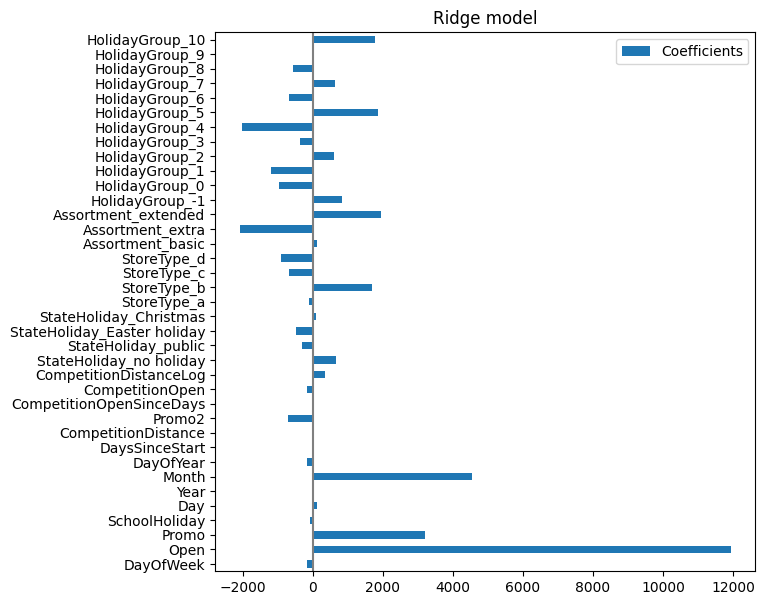

In [651]:
predictor_full = LinearRegression().fit(X, y)

coefs = pd.DataFrame(
   predictor_full.coef_,
   columns=['Coefficients'], index=X.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)